In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/

/gdrive/My Drive


In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

valid_data_gen = ImageDataGenerator(rescale=1/255., validation_split=0.2)

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=90,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        shear_range=0.2,
                                        validation_split=0.2,
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory='/gdrive/My Drive/AN2DL/training_data_final',
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=64,
                                                       subset='training',
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory('/gdrive/My Drive/AN2DL/training_data_final',
                                              target_size=(256,256),
                                              batch_size=64,
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              classes=None,
                                              subset='validation',
                                              shuffle=True,
                                              seed=seed)

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [ ]:
print("Assigned labels")
print(aug_train_gen.class_indices)
print()
print("Target classes")
print(aug_train_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [ ]:
input_shape = (256, 256, 3)
epochs = 200

# Generating class weights
To handle imbalanced classes

dict_items([(0, 149), (1, 426), (2, 412), (3, 409), (4, 425), (5, 178), (6, 430), (7, 407)])


<BarContainer object of 8 artists>

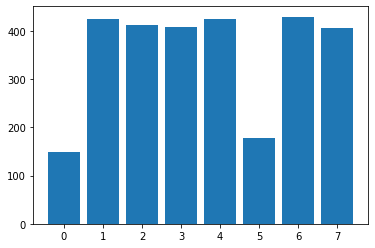

In [ ]:
from collections import Counter

counter = Counter(aug_train_gen.classes)

print(counter.items())

plt.bar(list(counter.keys()),list(counter.values()))

In [ ]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
            classes=np.unique(aug_train_gen.classes), 
            y=aug_train_gen.classes)
class_weights_dict = dict(zip(np.unique(aug_train_gen.classes), class_weights)),
class_weights_dict

# CNN built from scratch

In [ ]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D()(conv4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D()(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    dropout = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Build model (for  augmentation training)
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

In [ ]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug')

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

Epoch 1/100
23/23 [==============================] - 415s 18s/step - loss: 5.3876 - accuracy: 0.1707 - val_loss: 1.8955 - val_accuracy: 0.2408
Epoch 2/100
23/23 [==============================] - 48s 2s/step - loss: 1.8446 - accuracy: 0.2870 - val_loss: 1.8789 - val_accuracy: 0.2592
Epoch 3/100
23/23 [==============================] - 49s 2s/step - loss: 1.7928 - accuracy: 0.2906 - val_loss: 1.8720 - val_accuracy: 0.2436
Epoch 4/100
23/23 [==============================] - 48s 2s/step - loss: 1.7373 - accuracy: 0.3068 - val_loss: 1.6750 - val_accuracy: 0.3116
Epoch 5/100
23/23 [==============================] - 48s 2s/step - loss: 1.5921 - accuracy: 0.3946 - val_loss: 1.5763 - val_accuracy: 0.3796
Epoch 6/100
23/23 [==============================] - 47s 2s/step - loss: 1.5804 - accuracy: 0.4207 - val_loss: 1.6254 - val_accuracy: 0.3598
Epoch 7/100
23/23 [==============================] - 48s 2s/step - loss: 1.5076 - accuracy: 0.4369 - val_loss: 1.7682 - val_accuracy: 0.3782
Epoch 8/100

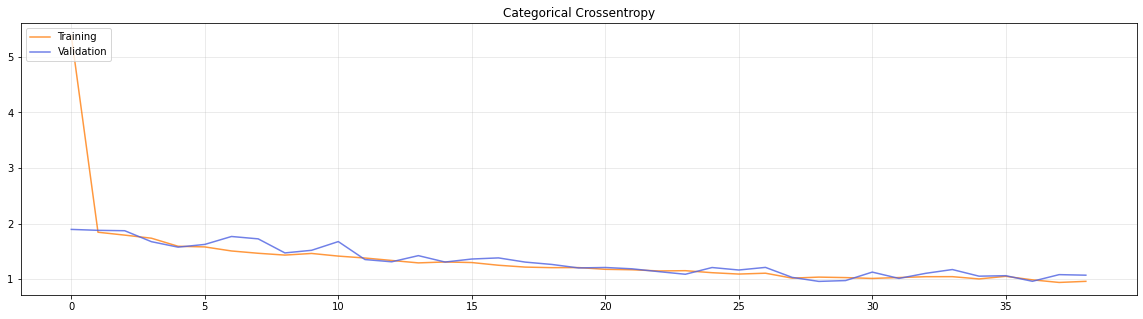

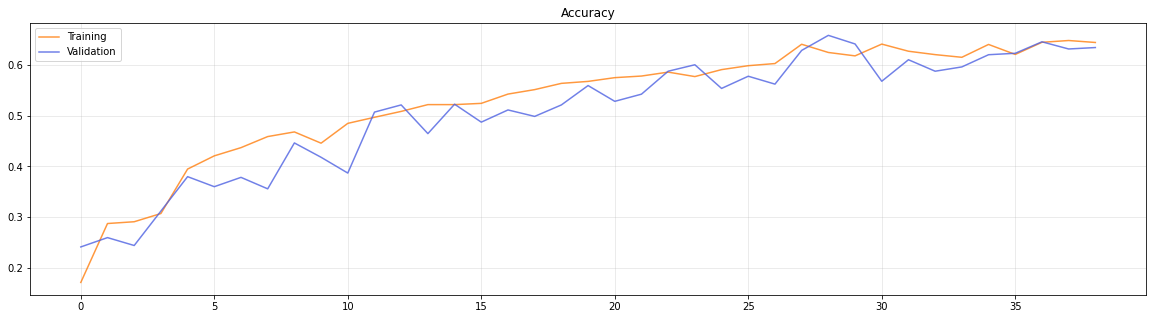

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_Aug_Best128")

# Transfer Learning - ResNet50V2

In [ ]:
resnet = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

model_resnet = tf.keras.Sequential()
model_resnet.add(resnet)
model_resnet.add(tf.keras.layers.Flatten())
model_resnet.add(tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_resnet.add(tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_resnet.add(tf.keras.layers.Dense(units=8, activation='softmax'))

model_resnet.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 64)                8388672   
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
Total params: 31,955,816
Trainable params: 31,910,376
Non-trainable params: 45,440
______________________________________

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = ['accuracy']
model_resnet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Create folders and callbacks and fit
resnet50_callbacks = create_folders_and_callbacks(model_name='CNN_TF_RESNET50')

# Train the model
history = model_resnet.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = resnet50_callbacks,
).history

Epoch 1/100
23/23 [==============================] - 81s 3s/step - loss: 1.9217 - accuracy: 0.2817 - val_loss: 2.3552 - val_accuracy: 0.1926
Epoch 2/100
23/23 [==============================] - 66s 3s/step - loss: 1.5659 - accuracy: 0.4376 - val_loss: 2.4690 - val_accuracy: 0.2450
Epoch 3/100
23/23 [==============================] - 66s 3s/step - loss: 1.3425 - accuracy: 0.5261 - val_loss: 2.7071 - val_accuracy: 0.2790
Epoch 4/100
23/23 [==============================] - 66s 3s/step - loss: 1.1976 - accuracy: 0.5832 - val_loss: 2.6322 - val_accuracy: 0.3329
Epoch 5/100
23/23 [==============================] - 65s 3s/step - loss: 1.0665 - accuracy: 0.6382 - val_loss: 2.3952 - val_accuracy: 0.3810
Epoch 6/100
23/23 [==============================] - 65s 3s/step - loss: 0.9988 - accuracy: 0.6580 - val_loss: 2.1095 - val_accuracy: 0.4334
Epoch 7/100
23/23 [==============================] - 65s 3s/step - loss: 0.8868 - accuracy: 0.7031 - val_loss: 1.7643 - val_accuracy: 0.5142
Epoch 8/100
2

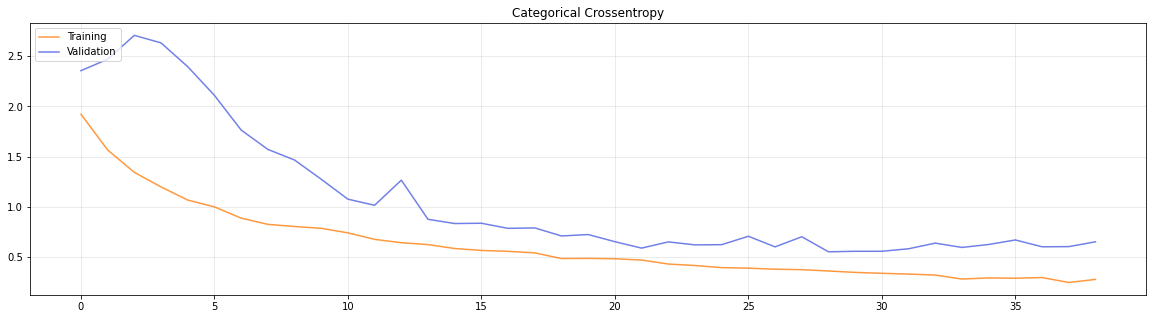

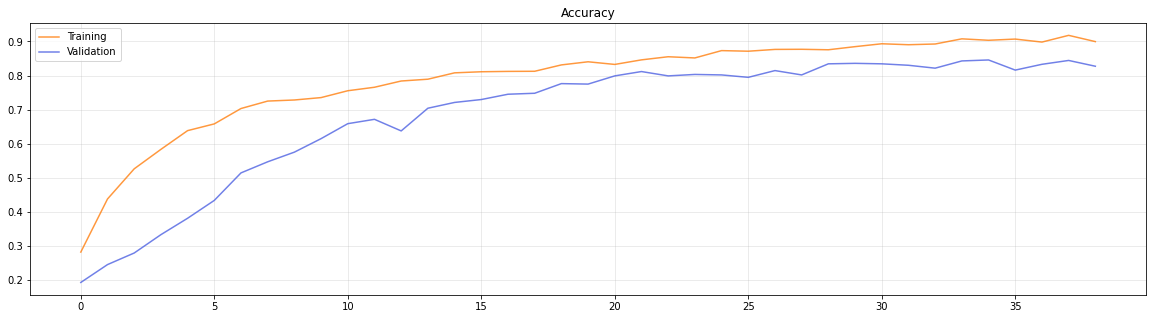

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Transfer Learning - VGG19



In [ ]:
model_vgg19 = tf.keras.Sequential()
vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
model_vgg19.add(vgg19)
model_vgg19.add(tf.keras.layers.Flatten())
model_vgg19.add(tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01),kernel_initializer = tfk.initializers.HeUniform(seed)))
model_vgg19.add(tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01),kernel_initializer = tfk.initializers.HeUniform(seed)))
model_vgg19.add(tf.keras.layers.Dense(units=8, activation='softmax'))

model_vgg19.compile(optimizer=optimizer, loss=loss, metrics=metrics)


model_vgg19.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
Total params: 22,123,944
Trainable params: 22,123,944
Non-trainable params: 0
_____________________________________________

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 5e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = ['accuracy']
model_vgg19.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Create folders and callbacks and fit
vgg19_callbacks = create_folders_and_callbacks(model_name='CNN_TL_VGG19_BS64')

# Train the model
vgg19_history = model_vgg19.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = vgg19_callbacks,
).history

Epoch 1/200
45/45 [==============================] - 93s 2s/step - loss: 3.5047 - accuracy: 0.3163 - val_loss: 3.1044 - val_accuracy: 0.4348
Epoch 2/200
45/45 [==============================] - 72s 2s/step - loss: 2.9206 - accuracy: 0.4644 - val_loss: 2.6913 - val_accuracy: 0.5014
Epoch 3/200
45/45 [==============================] - 72s 2s/step - loss: 2.6458 - accuracy: 0.5060 - val_loss: 2.6482 - val_accuracy: 0.4674
Epoch 4/200
45/45 [==============================] - 72s 2s/step - loss: 2.4100 - accuracy: 0.5638 - val_loss: 2.6115 - val_accuracy: 0.4703
Epoch 5/200
45/45 [==============================] - 78s 2s/step - loss: 2.1892 - accuracy: 0.6266 - val_loss: 2.0799 - val_accuracy: 0.6176
Epoch 6/200
45/45 [==============================] - 72s 2s/step - loss: 2.0323 - accuracy: 0.6756 - val_loss: 1.8745 - val_accuracy: 0.7125
Epoch 7/200
45/45 [==============================] - 72s 2s/step - loss: 1.9391 - accuracy: 0.6911 - val_loss: 1.9099 - val_accuracy: 0.7068
Epoch 8/200
4

In [ ]:
model_vgg19.save("data_augmentation_experiments/CNN_TL_VGG19_BS64")

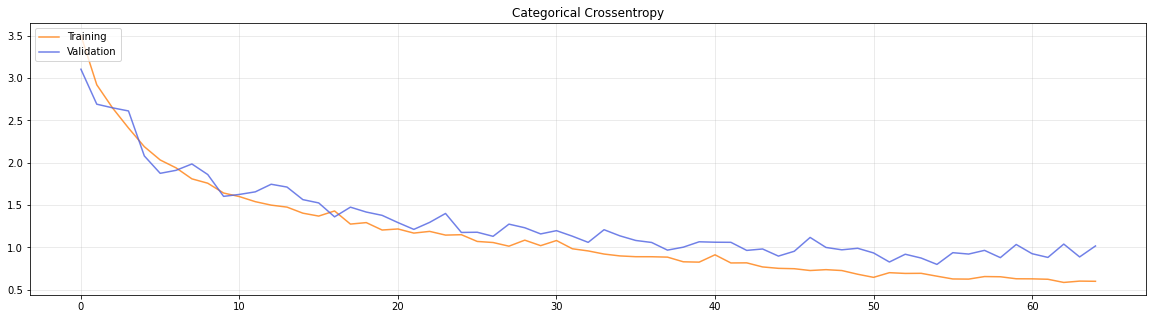

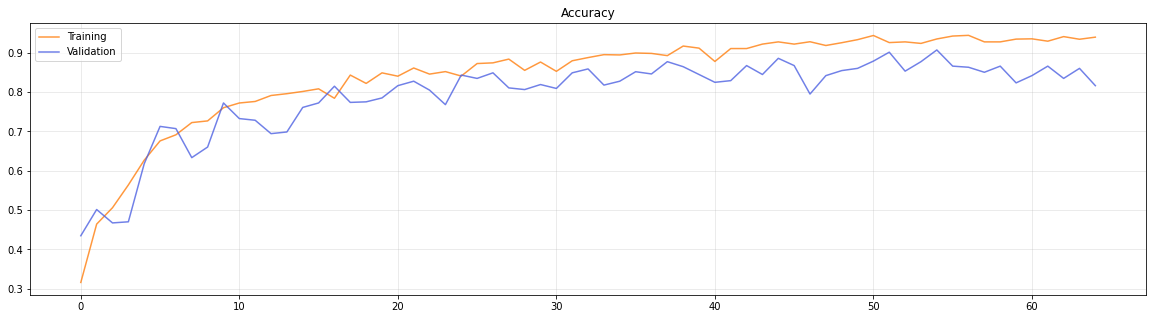

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(vgg19_history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(vgg19_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(vgg19_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(vgg19_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## Fine Tuning - VGG19

In [ ]:
## Fine Tuning VGG19
ft_vgg19_model = tfk.models.load_model("data_augmentation_experiments/CNN_TL_VGG19_BS64")
ft_vgg19_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                2097216   
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
Total params: 22,123,944
Trainable params: 22,123,944
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ft_vgg19_model.get_layer('vgg19').trainable = True
for i, layer in enumerate(ft_vgg19_model.get_layer('vgg19').layers):
   print(i, layer.name, ft_vgg19_model.trainable)

0 input_2 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [ ]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_vgg19_model.get_layer('vgg19').layers[:17]):
  layer.trainable=False
for i, layer in enumerate(ft_vgg19_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
ft_vgg19_model.summary()

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool False
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                2097216   
                                                         

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 5e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = ['accuracy']
ft_vgg19_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# Create folders and callbacks and fit
vgg19_ft_callbacks = create_folders_and_callbacks(model_name='CNN_TL_VGG19_BS64_FT')

# Train the model
ft_vgg19_history = ft_vgg19_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = vgg19_ft_callbacks,
).history

AttributeError: ignored

# Transfer Learning - InceptionV3
Adam Optimizer

In [ ]:
iv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
model_iv3 = tf.keras.Sequential()
model_iv3.add(iv3)
model_iv3.add(tf.keras.layers.Flatten())
model_iv3.add(tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_iv3.add(tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_iv3.add(tf.keras.layers.Dense(units=8, activation='softmax'))

model_iv3.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 64)                4718656   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
Total params: 26,523,784
Trainable params: 26,489,352
Non-trainable params: 34,432
________________________________________

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = ['accuracy']
model_iv3.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Create folders and callbacks and fit
iv3_callbacks = create_folders_and_callbacks(model_name='CNN_TF_IV3')

# Train the model
history = model_iv3.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = iv3_callbacks,
).history

Epoch 1/100
39/39 [==============================] - 1832s 46s/step - loss: 2.0366 - accuracy: 0.2058 - val_loss: 1.9556 - val_accuracy: 0.2280
Epoch 2/100
39/39 [==============================] - 1678s 43s/step - loss: 1.8768 - accuracy: 0.2944 - val_loss: 1.8286 - val_accuracy: 0.3144
Epoch 3/100
39/39 [==============================] - 1687s 43s/step - loss: 1.7439 - accuracy: 0.3508 - val_loss: 1.6727 - val_accuracy: 0.3754
Epoch 4/100
39/39 [==============================] - 1670s 43s/step - loss: 1.5933 - accuracy: 0.4144 - val_loss: 1.5577 - val_accuracy: 0.4391
Epoch 5/100
39/39 [==============================] - 1666s 43s/step - loss: 1.4958 - accuracy: 0.4559 - val_loss: 1.4564 - val_accuracy: 0.4632
Epoch 6/100
39/39 [==============================] - 1674s 43s/step - loss: 1.3887 - accuracy: 0.5115 - val_loss: 1.3700 - val_accuracy: 0.5042
Epoch 7/100
39/39 [==============================] - 1632s 42s/step - loss: 1.3293 - accuracy: 0.5417 - val_loss: 1.3035 - val_accuracy:

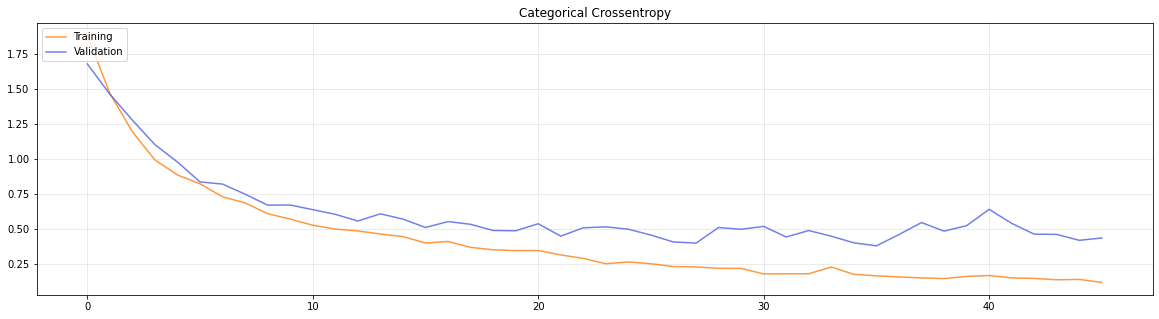

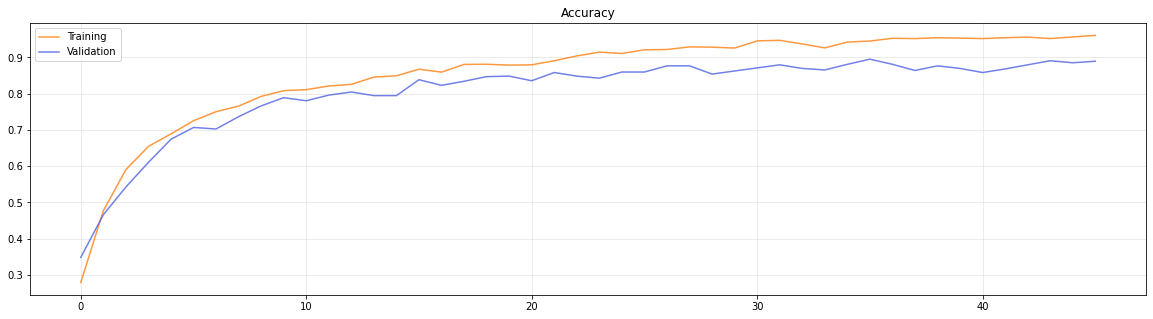

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save best epoch model
model_iv3.save("data_augmentation_experiments/CNN_TL_IV3_BS32")

# Transfer Learning - ResNet101V2
Adam Optimizer



In [ ]:
resnet101v2 = tf.keras.applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape)
model_resnet101v2 = tf.keras.Sequential()
model_resnet101v2.add(resnet101v2)
model_resnet101v2.add(tf.keras.layers.Flatten())
model_resnet101v2.add(tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_resnet101v2.add(tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_resnet101v2.add(tf.keras.layers.Dense(units=8, activation='softmax'))

model_resnet101v2.summary()

171317808/171317808 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 8, 8, 2048)        42626560  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 64)                8388672   
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
Total params: 51,017,576
Trainable params: 50,919,912
Non-trainable params: 97,664
____________________________________

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 5e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = ['accuracy']
model_resnet101v2.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Create folders and callbacks and fit
resnet101v2_callbacks = create_folders_and_callbacks(model_name='CNN_TF_RESNET101V2')

# Train the model
history = model_resnet101v2.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = resnet101v2_callbacks,
).history

Epoch 1/200
45/45 [==============================] - 98s 2s/step - loss: 1.9137 - accuracy: 0.3138 - val_loss: 2.0017 - val_accuracy: 0.2989
Epoch 2/200
45/45 [==============================] - 78s 2s/step - loss: 1.4115 - accuracy: 0.5173 - val_loss: 2.2200 - val_accuracy: 0.3768
Epoch 3/200
45/45 [==============================] - 79s 2s/step - loss: 1.1548 - accuracy: 0.6037 - val_loss: 1.9130 - val_accuracy: 0.4561
Epoch 4/200
45/45 [==============================] - 77s 2s/step - loss: 1.0005 - accuracy: 0.6562 - val_loss: 1.5057 - val_accuracy: 0.5538
Epoch 5/200
45/45 [==============================] - 79s 2s/step - loss: 0.8479 - accuracy: 0.7165 - val_loss: 1.2051 - val_accuracy: 0.6317
Epoch 6/200
45/45 [==============================] - 79s 2s/step - loss: 0.7675 - accuracy: 0.7437 - val_loss: 0.9611 - val_accuracy: 0.7082
Epoch 7/200
45/45 [==============================] - 77s 2s/step - loss: 0.6789 - accuracy: 0.7676 - val_loss: 0.8072 - val_accuracy: 0.7564
Epoch 8/200
4

In [ ]:
model_resnet101v2.save("data_augmentation_experiments/CNN_TL_RESNET101V2_BS64")

## Fine Tuning - ResNet101V2

In [ ]:
## Fine Tuning
ft_model = tfk.models.load_model("data_augmentation_experiments/CNN_TL_RESNET101V2_BS64")
ft_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 8, 8, 2048)        42626560  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 64)                8388672   
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
Total params: 51,017,576
Trainable params: 50,919,912
Non-trainable params: 97,664
_________________________________________________________________


In [ ]:
ft_model.get_layer('resnet101v2').trainable = True
for i, layer in enumerate(ft_model.get_layer('resnet101v2').layers):
   print(i, layer.name, layer.trainable)

0 input_2 True
1 conv1_pad True
2 conv1_conv True
3 pool1_pad True
4 pool1_pool True
5 conv2_block1_preact_bn True
6 conv2_block1_preact_relu True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_pad True
11 conv2_block1_2_conv True
12 conv2_block1_2_bn True
13 conv2_block1_2_relu True
14 conv2_block1_0_conv True
15 conv2_block1_3_conv True
16 conv2_block1_out True
17 conv2_block2_preact_bn True
18 conv2_block2_preact_relu True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_pad True
23 conv2_block2_2_conv True
24 conv2_block2_2_bn True
25 conv2_block2_2_relu True
26 conv2_block2_3_conv True
27 conv2_block2_out True
28 conv2_block3_preact_bn True
29 conv2_block3_preact_relu True
30 conv2_block3_1_conv True
31 conv2_block3_1_bn True
32 conv2_block3_1_relu True
33 conv2_block3_2_pad True
34 conv2_block3_2_conv True
35 conv2_block3_2_bn True
36 conv2_block3_2_relu True
37 max_pooling2d True

In [ ]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('resnet101v2').layers[:341]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('resnet101v2').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 5e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = ['accuracy']
ft_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# Create folders and callbacks and fit
resnet101v2_ft_callbacks = create_folders_and_callbacks(model_name='CNN_TF_RESNET101V2')

# Train the model
history = ft_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = resnet101v2_ft_callbacks,
).history

Epoch 1/200
45/45 [==============================] - 571s 12s/step - loss: 0.2789 - accuracy: 0.9059 - val_loss: 0.5178 - val_accuracy: 0.8541
Epoch 2/200
45/45 [==============================] - 67s 1s/step - loss: 0.2663 - accuracy: 0.9136 - val_loss: 0.5337 - val_accuracy: 0.8541
Epoch 3/200
45/45 [==============================] - 67s 1s/step - loss: 0.2484 - accuracy: 0.9242 - val_loss: 0.4948 - val_accuracy: 0.8711
Epoch 4/200
45/45 [==============================] - 67s 1s/step - loss: 0.2452 - accuracy: 0.9210 - val_loss: 0.5637 - val_accuracy: 0.8569
Epoch 5/200
45/45 [==============================] - 64s 1s/step - loss: 0.2378 - accuracy: 0.9164 - val_loss: 0.4617 - val_accuracy: 0.8909
Epoch 6/200
45/45 [==============================] - 66s 1s/step - loss: 0.2043 - accuracy: 0.9379 - val_loss: 0.4629 - val_accuracy: 0.8782
Epoch 7/200
45/45 [==============================] - 63s 1s/step - loss: 0.2141 - accuracy: 0.9305 - val_loss: 0.4915 - val_accuracy: 0.8768
Epoch 8/200

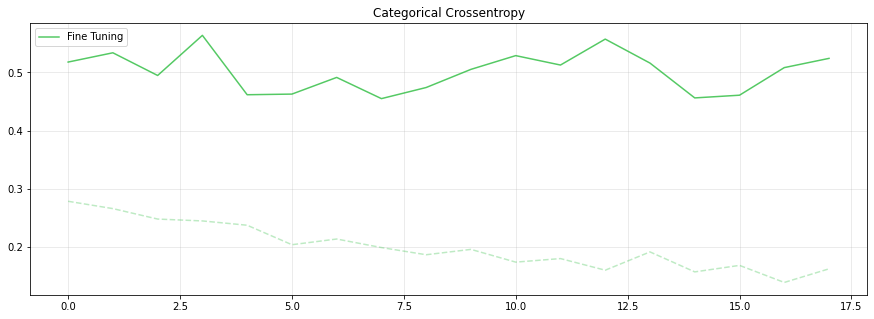

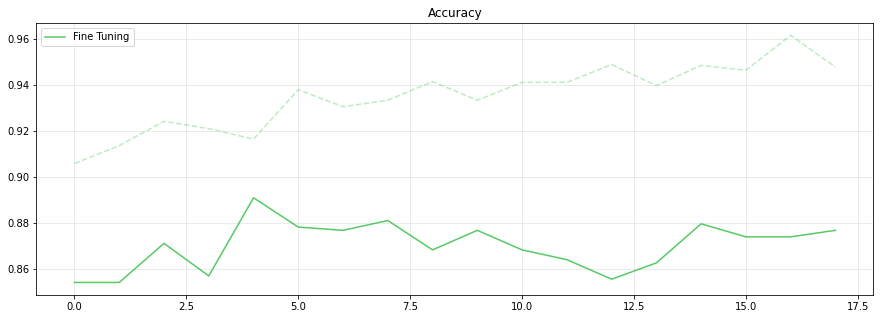

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
ft_model.save("data_augmentation_experiments/CNN_TL_RESNET101V2_BS64_FT")

# Keras Tuner - Failed Approach

In [ ]:
### KERAS TUNER
iv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
model_iv3 = tf.keras.Sequential()
model_iv3.add(iv3)
model_iv3.add(tf.keras.layers.Flatten())
model_iv3.add(tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_iv3.add(tf.keras.layers.Dense(units=32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
model_iv3.add(tf.keras.layers.Dense(units=8, activation='softmax'))

model_iv3.summary()

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner

def call_existing_code(dense_units_1, dense_units_2, activation, dropout, lr):
    iv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    model_iv3 = tf.keras.Sequential()
    model_iv3.add(tf.keras.layers.Flatten())
    model_iv3.add(tf.keras.layers.Dense(units=dense_units_1, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
    model_iv3.add(tf.keras.layers.Dense(units=dense_units_2, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(0.0001)))
    if dropout:
        model_iv3.add(tf.keras.layers.Dropout(rate=0.25))
    model_iv3.add(tf.keras.layers.Dense(8, activation="softmax"))
    model_iv3.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model_iv3


def build_model(hp):
    dense_units_1 = hp.Int("units1", min_value=32, max_value=256, step=32)
    dense_units_2 = hp.Int("units2", min_value=16, max_value=128, step=32)
    activation = hp.Choice("activation", ["relu", "tanh"])
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-5, max_value=1e-3, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(
        dense_units_1=dense_units_1, dense_units_2=dense_units_2, activation=activation, dropout=dropout, lr=lr
    )
    return model


#build_model(keras_tuner.HyperParameters())
tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_accuracy",
    max_epochs=10,
    directory="data_augmentation_experiments/KT_HP_1",
    project_name="AN2DL-Challenge1",
)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(aug_train_gen, val_gen, epochs=50, callbacks=[stop_early])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
128               |?                 |units1
80                |?                 |units2
tanh              |?                 |activation
False             |?                 |dropout
0.00055947        |?                 |lr
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
2                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 2.3956 - accuracy: 0.1460 

45/45 [==============================] - 478s 11s/step - loss: 2.3956 - accuracy: 0.1460
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 2.0993 - accuracy: 0.1361

45/45 [==============================] - 48s 1s/step - loss: 2.0993 - accuracy: 0.1361


KeyError: ignored

# Transfer Learning - InceptionV3
SGD Optimizer

In [ ]:
## InceptionV3
iv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
inputs = tfk.Input(shape=input_shape)
x = iv3(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)  
output_layer = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='tl_model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(), metrics=['accuracy'])


tl_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 Flattening (Flatten)        (None, 73728)             0         
                                                                 
 dropout (Dropout)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 8)                 589832    
                                                                 
Total params: 22,392,616
Trainable params: 22,358,184
Non-trainable params: 34,432
__________________________________________

In [ ]:
# Create folders and callbacks and fit
iv3_tl_callbacks = create_folders_and_callbacks(model_name='CNN_TL_EX_IV3_BS64_SGD')

# Train the model
iv3_tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = iv3_tl_callbacks,
).history

Epoch 1/200
45/45 [==============================] - 482s 10s/step - loss: 3.0713 - accuracy: 0.1943 - val_loss: 3.2237 - val_accuracy: 0.1700
Epoch 2/200
45/45 [==============================] - 58s 1s/step - loss: 1.9590 - accuracy: 0.3607 - val_loss: 2.5067 - val_accuracy: 0.2450
Epoch 3/200
45/45 [==============================] - 58s 1s/step - loss: 1.5870 - accuracy: 0.4915 - val_loss: 1.7078 - val_accuracy: 0.3669
Epoch 4/200
45/45 [==============================] - 58s 1s/step - loss: 1.3419 - accuracy: 0.5681 - val_loss: 1.2499 - val_accuracy: 0.5439
Epoch 5/200
45/45 [==============================] - 57s 1s/step - loss: 1.2323 - accuracy: 0.6054 - val_loss: 1.1329 - val_accuracy: 0.5963
Epoch 6/200
45/45 [==============================] - 57s 1s/step - loss: 1.0159 - accuracy: 0.6693 - val_loss: 1.1038 - val_accuracy: 0.6331
Epoch 7/200
45/45 [==============================] - 57s 1s/step - loss: 0.9127 - accuracy: 0.6971 - val_loss: 0.9777 - val_accuracy: 0.6771
Epoch 8/200

In [ ]:
# Save best epoch model
tl_model.save("data_augmentation_experiments/CNN_TL_EX_IV3_BS64_SGD")

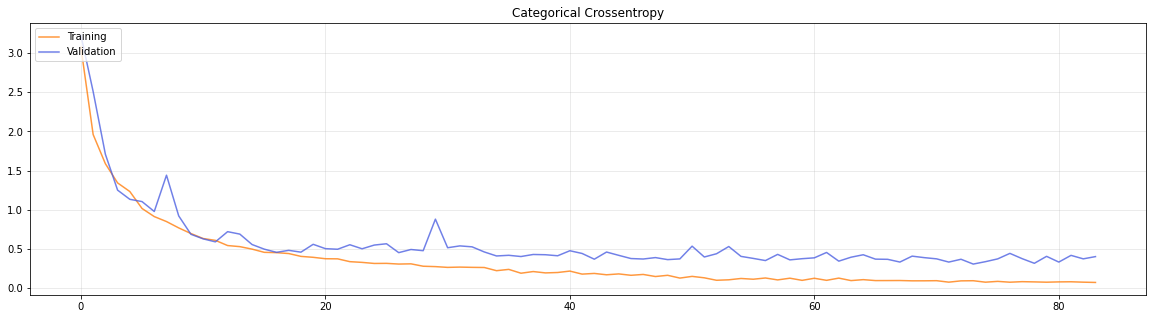

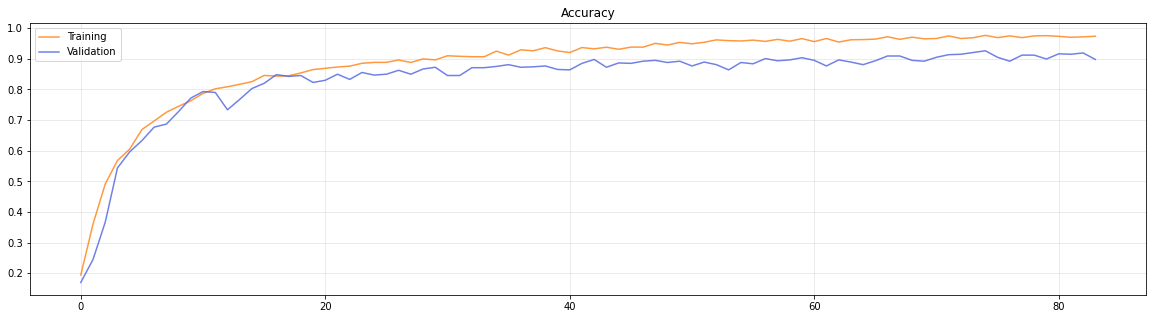

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(iv3_tl_history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(iv3_tl_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(iv3_tl_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(iv3_tl_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
tl_model.save("data_augmentation_experiments/CNN_TL_EX_IV3_BS64_SGD.h5")

# Training on Original and Augmented Data

In [ ]:
import shutil
sdir=r'AN2DL'
aug_dir=os.path.join(sdir,'augmented_images')
if os.path.isdir(aug_dir): # see if aug_dir exists if so remove it to get a clean slate
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir) # make a new empty aug_dir
filepaths=[]
labels=[]
# iterate through original_images and create a dataframe of the form filepaths, labels
original_images_dir=os.path.join(sdir, 'training_data_final')
target_names = ['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']
for klass in target_names:
    os.mkdir(os.path.join(aug_dir,klass)) # make the class subdirectories in the aug_dir
    classpath=os.path.join(original_images_dir, klass) # get the path to the classes
    flist=os.listdir(classpath)# for each class the the list of files in the class    
    for f in flist:        
        fpath=os.path.join(classpath, f) # get the path to the file
        filepaths.append(fpath)
        labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1) # create the dataframe
gen=ImageDataGenerator(rotation_range=90,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        shear_range=0.2,
                                        validation_split=0.2,
                                        rescale=1/255.)
groups=df.groupby('labels') # group by class
for label in df['labels'].unique():  # for every class               
    group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count=len(group)   # determine how many samples there are in this class  
    aug_img_count=0
    target_dir=os.path.join(aug_dir, label)  # define where to write the images    
    aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=(96,96), class_mode=None,
                                        batch_size=1, shuffle=False, save_to_dir=target_dir, save_prefix='aug-',
                                        save_format='jpg')
    while aug_img_count<len(group):
        images=next(aug_gen)            
        aug_img_count += len(images) 

Found 186 validated image filenames.
Found 532 validated image filenames.
Found 515 validated image filenames.
Found 511 validated image filenames.
Found 531 validated image filenames.
Found 222 validated image filenames.
Found 537 validated image filenames.
Found 508 validated image filenames.


In [ ]:
## Train on original and augmented data
from keras.preprocessing.image import ImageDataGenerator

valid_data_gen = ImageDataGenerator(rescale=1/255., validation_split=0.2)

# Create an instance of ImageDataGenerator with Data Augmentation
comb_train_data_gen = ImageDataGenerator(validation_split=0.2,
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = comb_train_data_gen.flow_from_directory(directory='/gdrive/My Drive/AN2DL/training_data_combined',
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=64,
                                                       subset='training',
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory('/gdrive/My Drive/AN2DL/training_data_combined',
                                              target_size=(256,256),
                                              batch_size=64,
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              classes=None,
                                              subset='validation',
                                              shuffle=True,
                                              seed=seed)

Found 5679 images belonging to 8 classes.
Found 1415 images belonging to 8 classes.


In [ ]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Species1': 0, 'Species2': 1, 'Species3': 2, 'Species4': 3, 'Species5': 4, 'Species6': 5, 'Species7': 6, 'Species8': 7}

Target classes
[0 0 0 ... 7 7 7]


In [ ]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
            classes=np.unique(train_gen.classes), 
            y=train_gen.classes)
class_weights_dict = dict(zip(np.unique(train_gen.classes), class_weights)),
class_weights_dict

({0: 2.3821308724832213,
  1: 0.8322098475967175,
  2: 0.8542418772563177,
  3: 0.8678178484107579,
  4: 0.8351470588235295,
  5: 1.9940308988764044,
  6: 0.8254360465116279,
  7: 0.8731549815498155},)

In [ ]:
## InceptionV3
iv3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
inputs = tfk.Input(shape=input_shape)
x = iv3(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)  
output_layer = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='tl_model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.SGD(), metrics=['accuracy'])


tl_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 Flattening (Flatten)        (None, 73728)             0         
                                                                 
 dropout (Dropout)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 8)                 589832    
                                                                 
Total params: 22,392,616
Trainable params: 22,358,184
Non-trainable params: 34,432
__________________________________________

In [ ]:
# Create folders and callbacks and fit
iv3_tl_callbacks = create_folders_and_callbacks(model_name='CNN_IV3_BS64_SGD_COMB')

# Train the model
iv3_tl_history = tl_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = iv3_tl_callbacks,
).history

Epoch 1/200
89/89 [==============================] - 4169s 47s/step - loss: 2.4809 - accuracy: 0.3277 - val_loss: 1.6987 - val_accuracy: 0.3237
Epoch 2/200
89/89 [==============================] - 4193s 47s/step - loss: 1.1749 - accuracy: 0.5769 - val_loss: 1.3841 - val_accuracy: 0.4615
Epoch 3/200
13/89 [===>..........................] - ETA: 54:58 - loss: 0.9095 - accuracy: 0.6863